Практическое задание:
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
    - для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [27]:
df = pd.read_csv('adult.data')

### 2. сделать обзорный анализ выбранного датасета

In [28]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [30]:
# Проврка пропусков
pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Проверка дубликатов
df.duplicated(keep=False).value_counts()

False    32514
True        47
dtype: int64

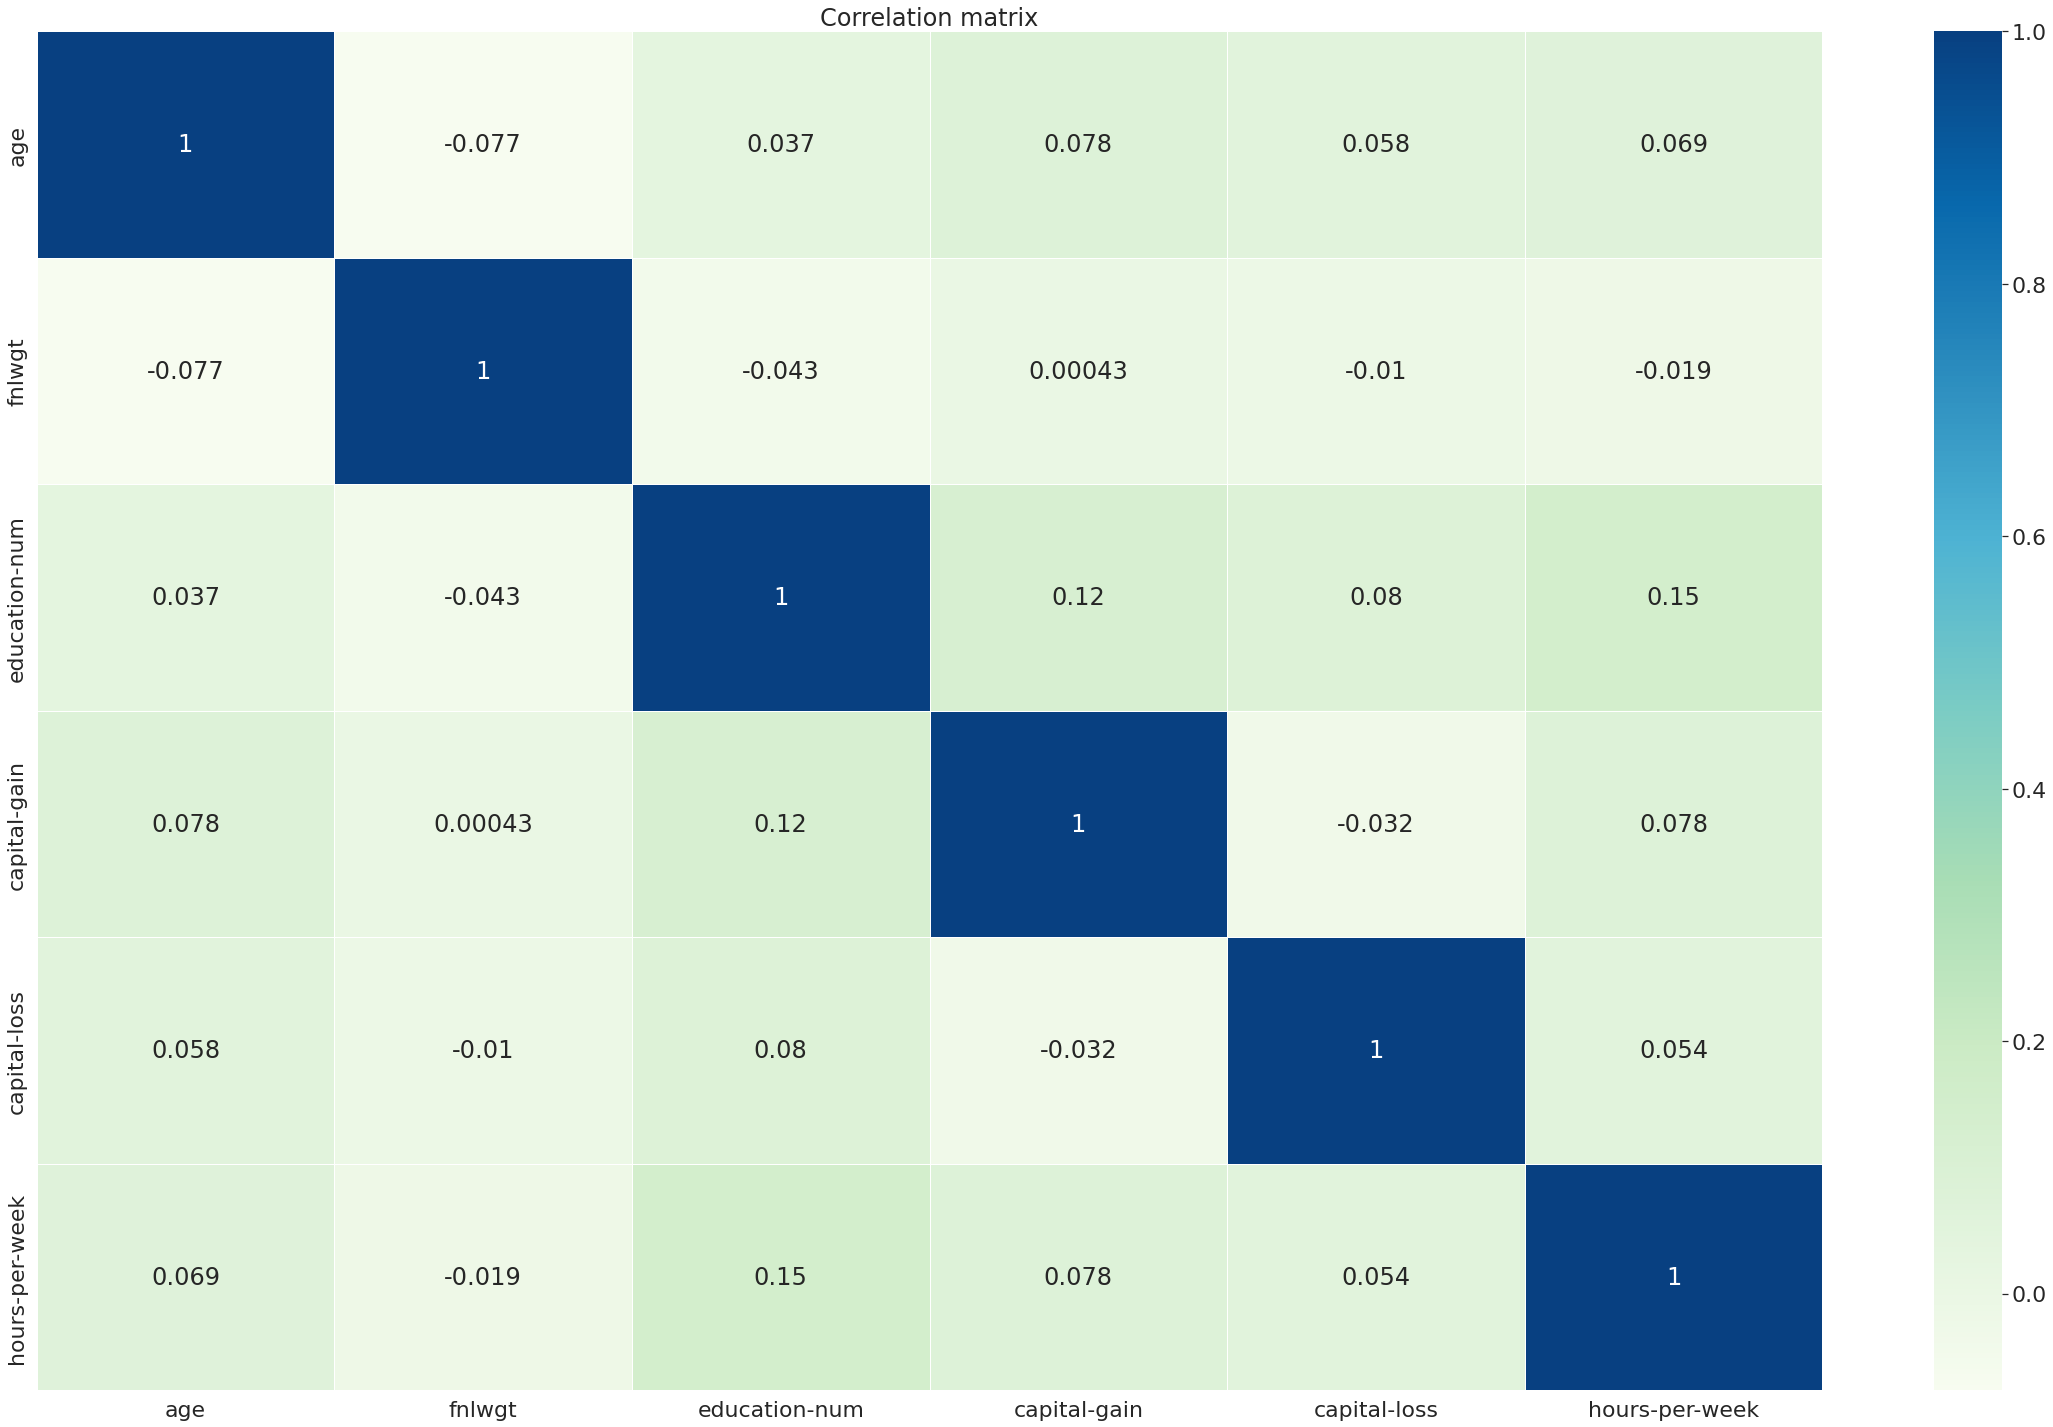

In [32]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### 3. сделать feature engineering

In [33]:
# Изменение целевой переменной
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

In [34]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop('income', axis=1))
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### 4. обучить любой классификатор (какой вам нравится)

In [35]:
%%time
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[18:44:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 24.4 s, sys: 8.03 ms, total: 24.4 s
Wall time: 1.05 s


In [36]:
def evaluate_results(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc
metrics,0.707,0.768,0.655,0.796


### 5. разобраться с SHAP и построить важности признаков для:

In [37]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [38]:
%%time

model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

CPU times: user 1min 16s, sys: 14.8 ms, total: 1min 16s
Wall time: 3.36 s


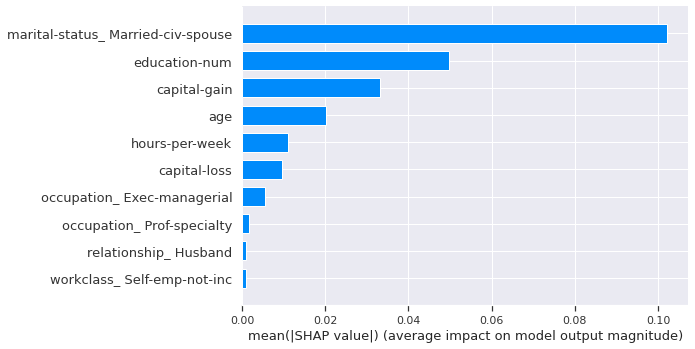

In [39]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

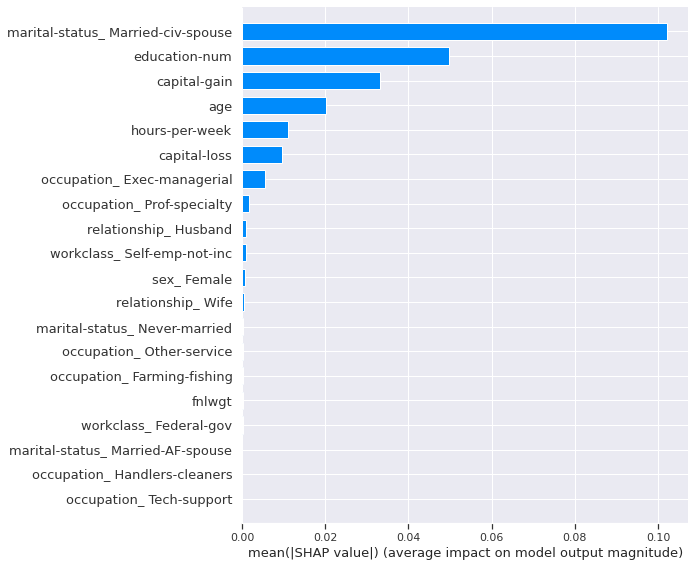

In [40]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [41]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

---

In [42]:
force_plot(sample_number=356)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
356,65,Private,161400,11th,7,Widowed,Other-service,Unmarried,Other,Male,0,0,40,United-States,0
